In [2]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
torch.__version__ 

'1.4.0'

In [4]:
import torchvision
torchvision.__version__  # should be 0.2.1

'0.5.0'

In [12]:
input_path = "C:/Users/Eubin/Desktop/plan B/NLMCXR/"

In [15]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'test':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize
    ]),
}

image_datasets = {
    'train': 
    datasets.ImageFolder(input_path + 'Train set', data_transforms['train']),
    'test': 
    datasets.ImageFolder(input_path + 'Test set', data_transforms['test'])
}

dataloaders = {
    'train':
    torch.utils.data.DataLoader(image_datasets['train'],
                                batch_size=32,
                                shuffle=True,
                                num_workers=0),  # for Kaggle
    'test':
    torch.utils.data.DataLoader(image_datasets['test'],
                                batch_size=32,
                                shuffle=False,
                                num_workers=0)  # for Kaggle
}

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to C:\Users\Eubin/.cache\torch\checkpoints\resnet50-19c8e357.pth
100.0%


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

In [20]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [22]:
model_trained = train_model(model, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------
train loss: 0.1417, acc: 0.9791
test loss: 0.0733, acc: 0.9750
Epoch 2/3
----------
train loss: 0.0938, acc: 0.9664
test loss: 0.0347, acc: 1.0000
Epoch 3/3
----------
train loss: 0.0662, acc: 0.9791
test loss: 0.0564, acc: 0.9875


In [30]:
#!mkdir models pytorch

하위 디렉터리 또는 파일 models이(가) 이미 있습니다.
다음 내용 진행 중 오류 발생: models.


In [31]:
torch.save(model_trained.state_dict(), 'models/weights.h5')

In [32]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 2)).to(device)
model.load_state_dict(torch.load('models/weights.h5'))

<All keys matched successfully>

In [34]:
test_img_paths = ["Test set/LAT/CXR467_IM-2095-2001.png",
                        "Test set/LAT/CXR468_IM-2096-2001.png",
                        "Test set/PA/CXR470_IM-2099-3001.png"]
img_list = [Image.open(input_path + img_path) for img_path in test_img_paths]

In [37]:
test_batch = torch.stack([data_transforms['test'](img).to(device)
                                for img in img_list])

In [38]:
pred_logits_tensor = model(test_batch)
pred_logits_tensor

tensor([[ 3.2645, -4.0943],
        [ 2.2519, -3.1092],
        [-3.5041,  2.8538]], grad_fn=<AddmmBackward>)

In [39]:
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
pred_probs

array([[9.993635e-01, 6.365588e-04],
       [9.953258e-01, 4.674136e-03],
       [1.730087e-03, 9.982699e-01]], dtype=float32)

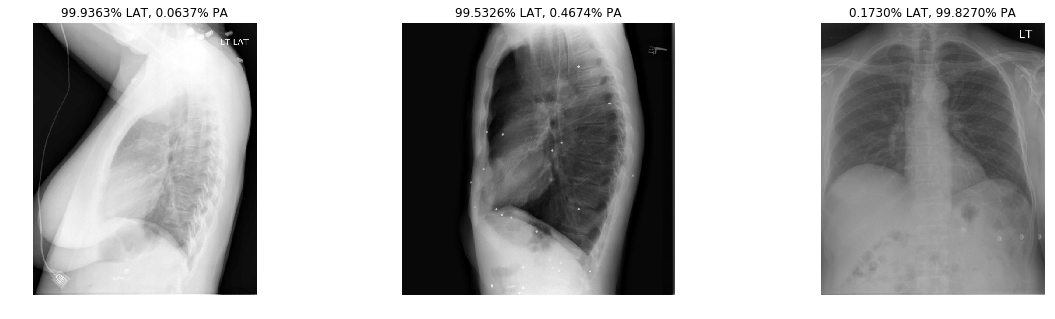

In [42]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.4f}% LAT, {:.4f}% PA".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)